In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, models, transforms
from collections import Counter

# Define the Vision Transformer Model
class VisionTransformer(nn.Module):
    def __init__(self, num_classes=2):
        super(VisionTransformer, self).__init__()
        self.model = models.vit_b_16(pretrained=True)
        self.model.heads.head = nn.Linear(self.model.heads.head.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(root="dataset/80_10_10/train_80_10_10", transform=transform)
val_data = datasets.ImageFolder(root="dataset/80_10_10/val_80_10_10", transform=transform)

# Calculate class weights to handle imbalance
class_counts = Counter([label for _, label in train_data])
class_weights = 1. / torch.tensor([class_counts[i] for i in range(len(class_counts))], dtype=torch.float)
sample_weights = [class_weights[label] for _, label in train_data]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Data loaders
train_loader = DataLoader(train_data, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

# Initialize model, criterion, optimizer
model = VisionTransformer(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_epoch(loader, model, criterion, optimizer):
    model.train()
    running_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train_epoch(train_loader, model, criterion, optimizer)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Loss: 0.9275
Epoch [2/5], Loss: 0.7163
Epoch [3/5], Loss: 0.7030
Epoch [4/5], Loss: 0.7163
Epoch [5/5], Loss: 0.6978


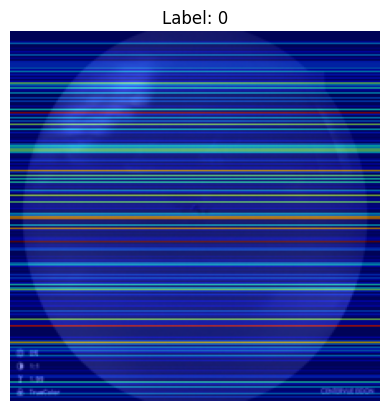

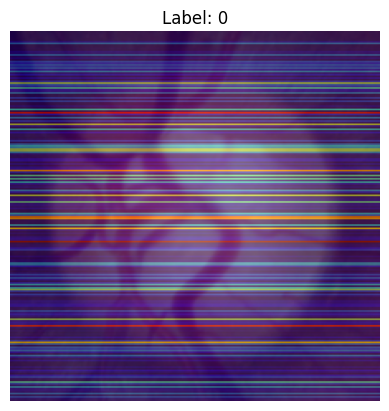

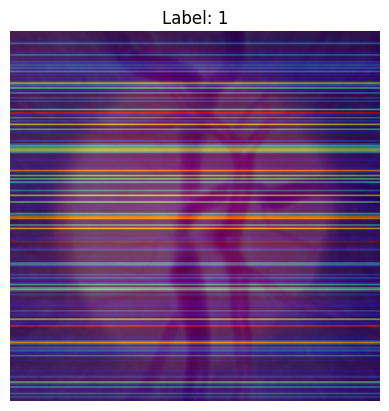

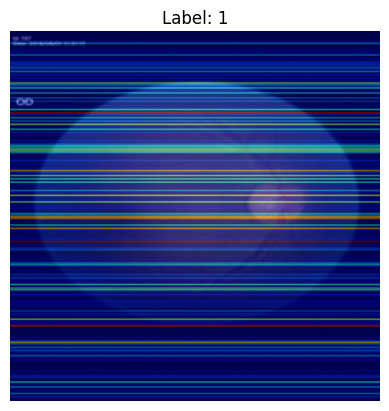

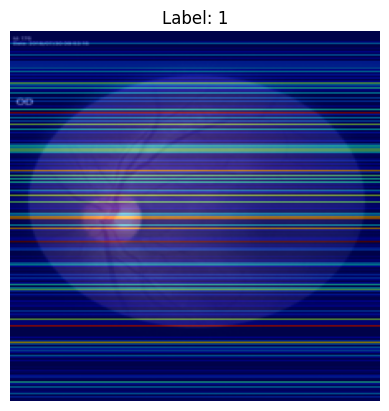

In [2]:
import matplotlib.pyplot as plt
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Set up a target layer for Eigen-CAM
target_layer = model.model.encoder.layers[-1].ln_2  # Adjusted for ViT compatibility
cam = EigenCAM(model=model, target_layers=[target_layer])

# Function to apply Eigen-CAM to an image
def apply_eigencam(image, label):
    model.eval()
    input_tensor = image.unsqueeze(0).to(device) 
    targets = [ClassifierOutputTarget(label)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
    
    # Convert image to a numpy format for display with CAM
    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    
    # Overlay the heatmap on the original image
    cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)
    return cam_image

# Evaluate and visualize a few validation images with their labels
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        for i in range(len(images)):
            cam_image = apply_eigencam(images[i], labels[i].item())
            plt.imshow(cam_image)
            plt.title(f"Label: {labels[i].item()}")
            plt.axis('off')
            plt.show()
            if i >= 4:  # Show only a few images
                break
        break  # Break after the first batch


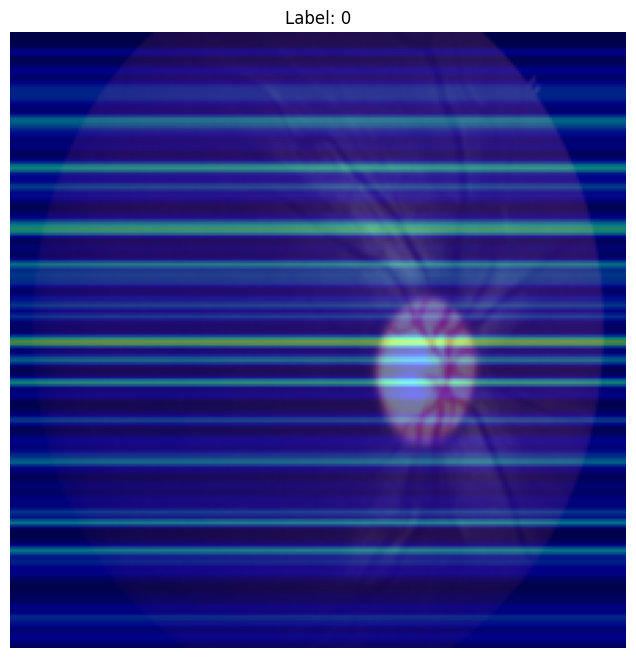

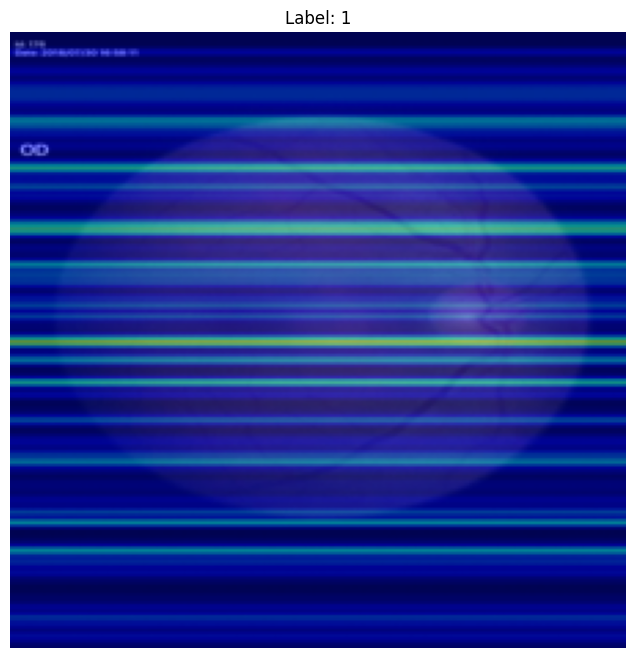

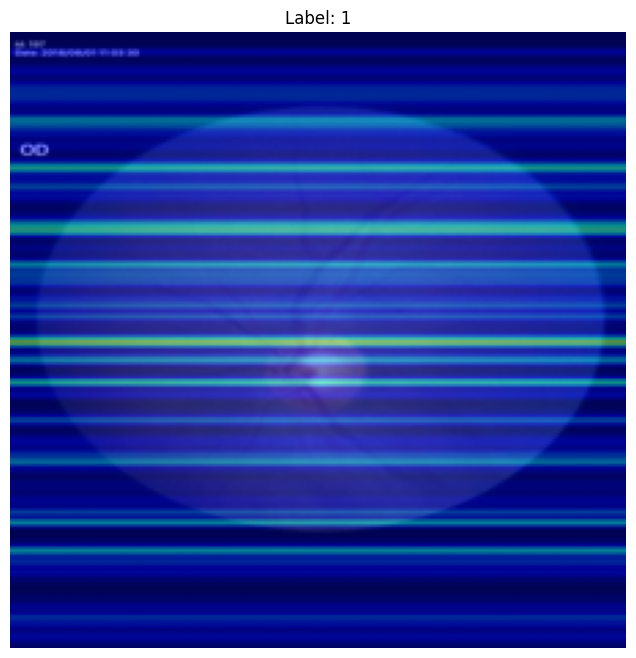

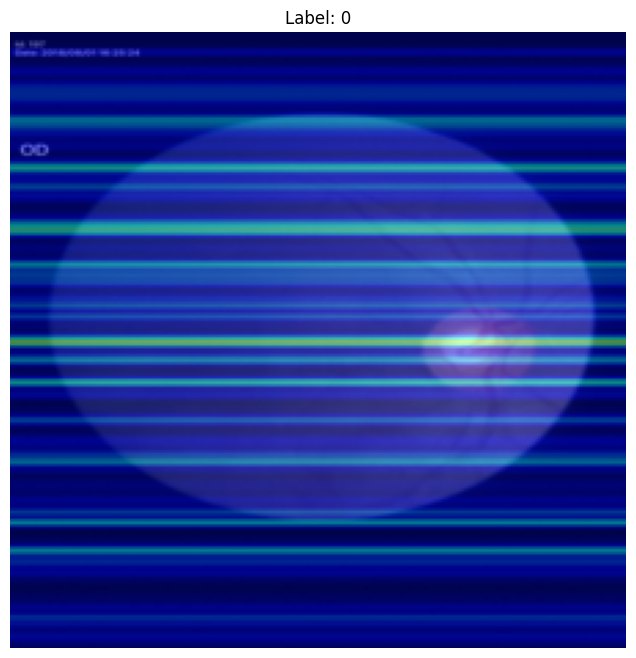

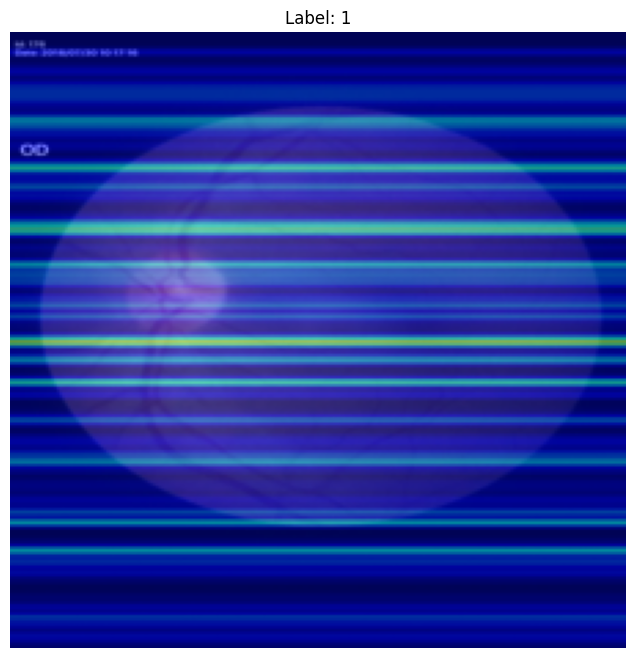

In [3]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2  # For Gaussian blurring

# Set up a target layer for Eigen-CAM
target_layer = model.model.encoder.layers[-1].ln_2  # Adjusted for ViT compatibility
cam = EigenCAM(model=model, target_layers=[target_layer])

# Function to apply Eigen-CAM to an image
def apply_eigencam(image, label):
    model.eval()
    input_tensor = image.unsqueeze(0).to(device)
    targets = [ClassifierOutputTarget(label)]
    
    # Generate the CAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

    # Normalize CAM
    grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)

    # Apply Gaussian blur to the CAM for smoother transitions
    # No need to call .numpy() since grayscale_cam is already a NumPy array
    grayscale_cam = cv2.GaussianBlur(grayscale_cam, (5, 5), 0)

    # Convert image to a numpy format for display with CAM
    image_np = image.permute(1, 2, 0).detach().cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min() + 1e-8)

    # Overlay the heatmap on the original image
    cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

    return cam_image

# Evaluate and visualize a few validation images with their labels
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        for i in range(len(images)):
            cam_image = apply_eigencam(images[i], labels[i].item())
            plt.figure(figsize=(8, 8))
            plt.imshow(cam_image)
            plt.title(f"Label: {labels[i].item()}")
            plt.axis('off')
            plt.show()
            if i >= 4:  # Show only a few images
                break
        break  # Break after the first batch


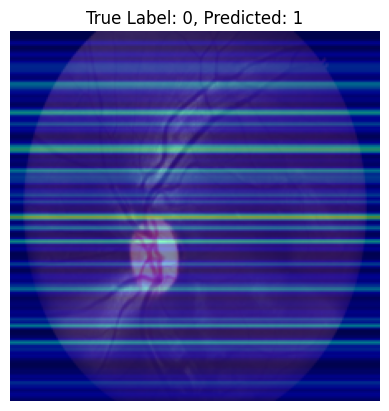

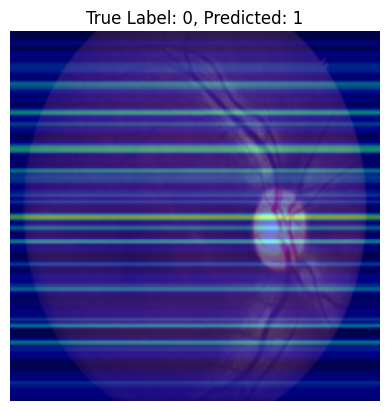

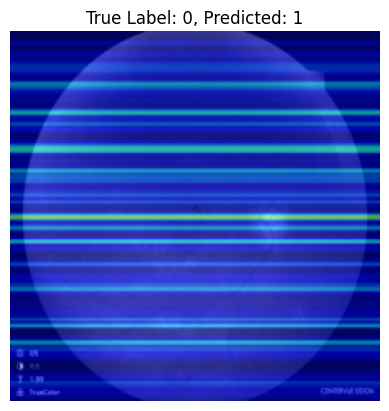

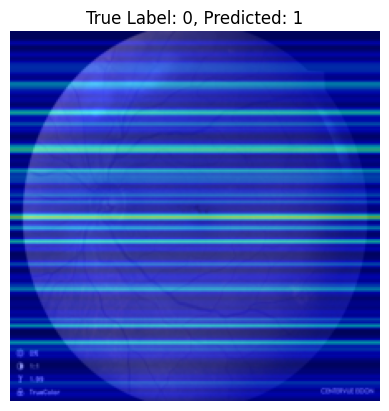

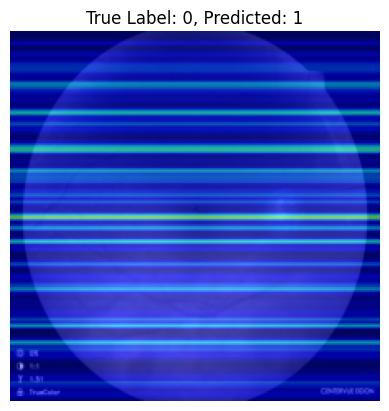

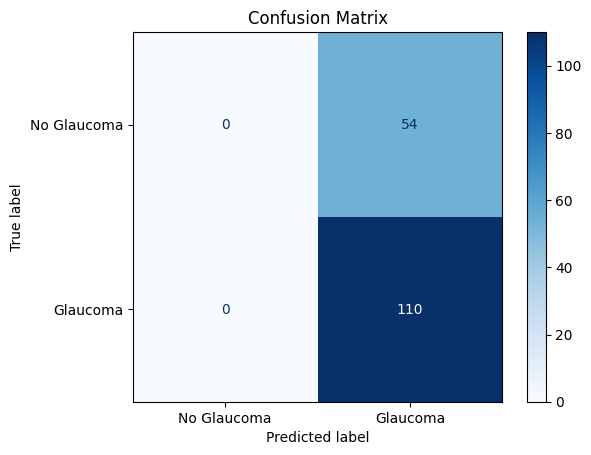

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# (Assuming the previous parts of your code for training and applying XAI are here)

# Test the model on all images from the test data and display confusion matrix
test_data = datasets.ImageFolder(root="dataset/80_10_10/test_80_10_10", transform=transform)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)  # Load all test images

# Prepare for confusion matrix
all_labels = []
all_predictions = []

# Counter for visualized samples
visualized_samples = 0
max_visualizations = 5  # Limit the number of visualizations

# Evaluate all test images
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Collect all labels and predictions for confusion matrix
        all_labels.append(labels.item())
        all_predictions.append(predicted.item())

        # Visualize the test image and prediction for a few samples
        if visualized_samples < max_visualizations:
            cam_image = apply_eigencam(images[0], predicted[0].item())
            plt.imshow(cam_image)
            plt.title(f"True Label: {labels.item()}, Predicted: {predicted.item()}")
            plt.axis('off')
            plt.show()
            visualized_samples += 1

# Calculate and display confusion matrix after evaluating all images
cm = confusion_matrix(all_labels, all_predictions, labels=[0, 1])  # Assuming binary classification (0 and 1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Glaucoma', 'Glaucoma'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [5]:
import torch

# Save the model's state_dict
torch.save(model.state_dict(), "model/best_model.pth")


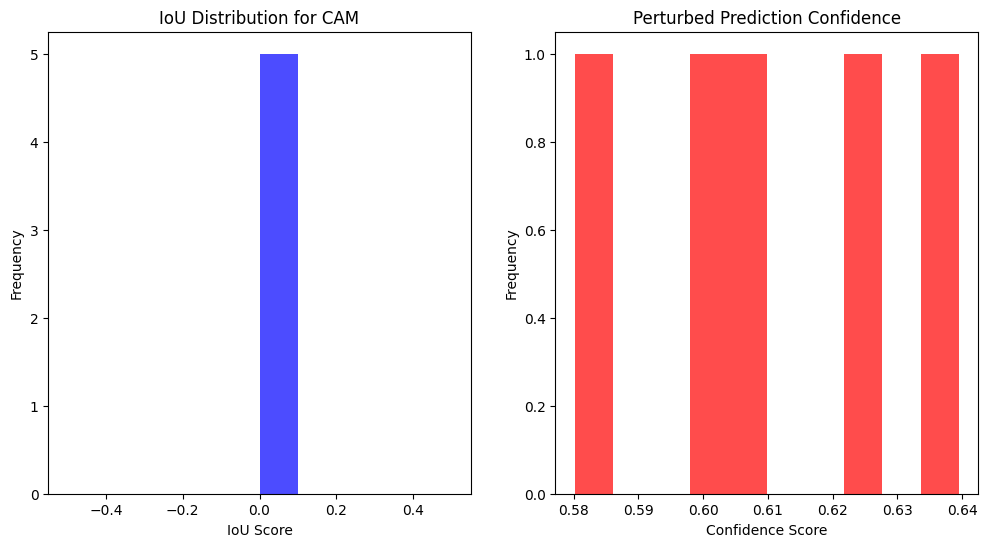

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6152923].


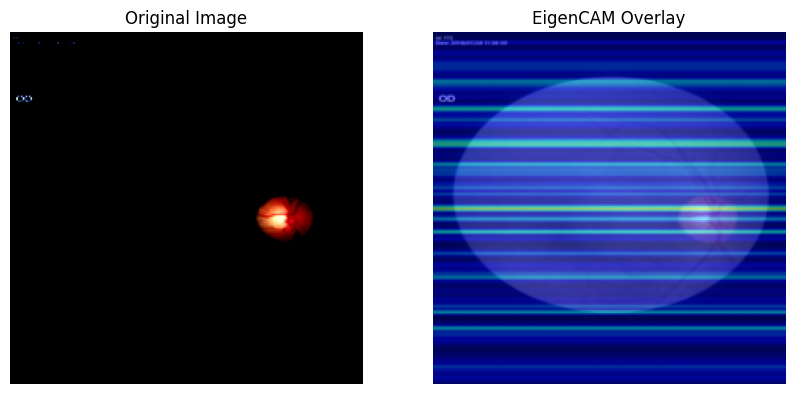

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.5296686].


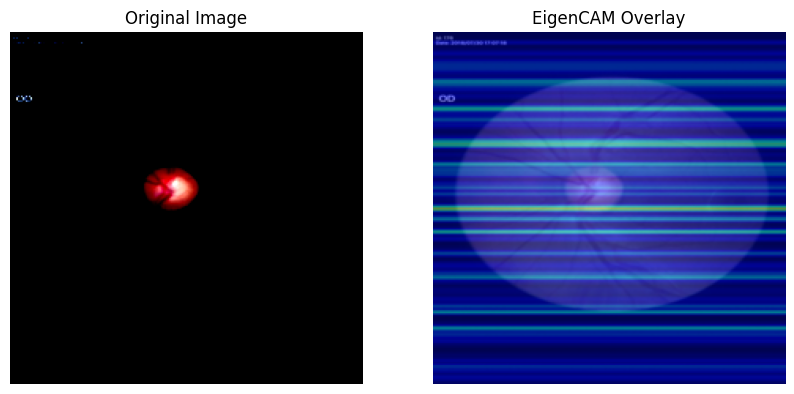

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6837914].


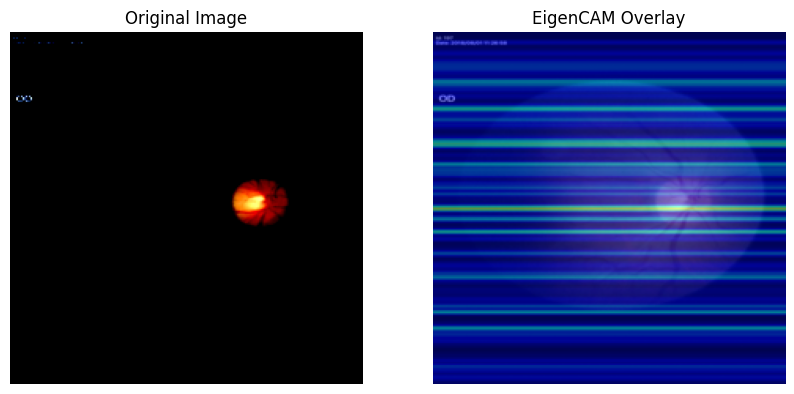

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8036647].


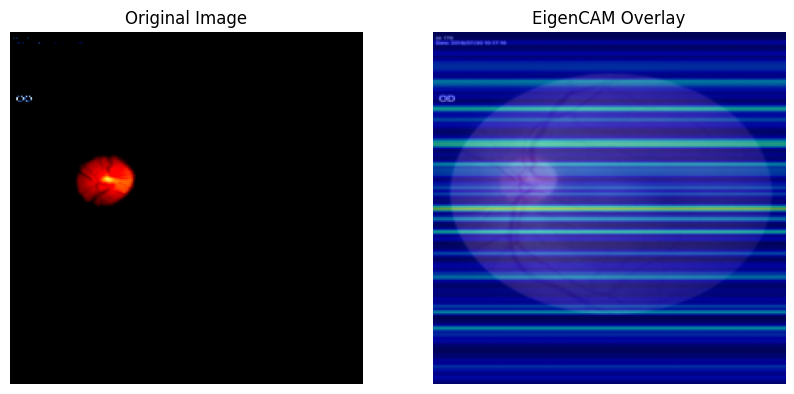

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7380952..1.5467933].


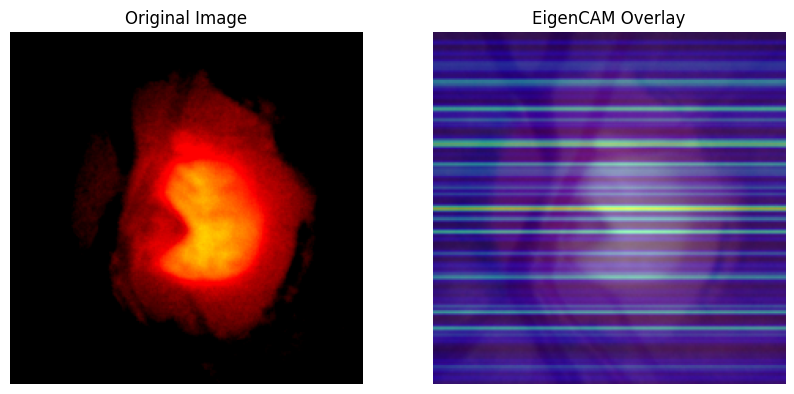

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import jaccard_score  # For IoU
import torch

# Suppose `apply_eigencam` function from the previous response is already defined.
# Adjust this part based on available ground-truth masks, if any.

def calculate_iou(cam_mask, gt_mask):
    """
    Calculate the Intersection over Union (IoU) score between the CAM mask and ground-truth mask.
    Arguments:
        cam_mask: np.array, binary CAM heatmap.
        gt_mask: np.array, binary ground-truth mask.
    """
    cam_flat = cam_mask.flatten()
    gt_flat = gt_mask.flatten()
    iou_score = jaccard_score(gt_flat, cam_flat)
    return iou_score

def perturb_image(image, mask, intensity=0.5):
    """
    Zero-out the areas in the image where the CAM has the highest intensities.
    Arguments:
        image: np.array, the original image.
        mask: np.array, the CAM heatmap mask.
        intensity: float, controls the severity of perturbation.
    """
    perturbed_image = image.copy()
    perturbed_image[mask > intensity] = 0
    return perturbed_image

# Function to evaluate and visualize CAM on a few validation images
def evaluate_cam_with_metrics(val_loader, model, cam, threshold=0.5):
    model.eval()
    iou_scores = []
    all_images = []
    all_cam_images = []
    all_perturbed_confidences = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            for i in range(len(images)):
                # Apply CAM
                cam_image = apply_eigencam(images[i], labels[i].item())
                cam_mask = (cam_image[..., 0] > threshold).astype(np.uint8)  # Binary mask based on threshold

                # IoU score calculation (requires ground-truth mask, replace with actual if available)
                gt_mask = np.zeros_like(cam_mask)  # Replace with actual ground truth if available
                iou_score = calculate_iou(cam_mask, gt_mask)
                iou_scores.append(iou_score)

                # Perturb the image based on the CAM mask and calculate model confidence
                perturbed_image = perturb_image(images[i].permute(1, 2, 0).cpu().numpy(), cam_mask)
                perturbed_input = torch.tensor(perturbed_image).permute(2, 0, 1).unsqueeze(0).to(device)
                perturbed_confidence = model(perturbed_input).softmax(dim=1).max().item()
                all_perturbed_confidences.append(perturbed_confidence)

                # Collect images for visualization
                all_images.append(images[i].cpu().numpy())
                all_cam_images.append(cam_image)
                if i >= 4:  # Show only a few images
                    break
            break  # Break after the first batch

    # Plot IoU and Perturbed Confidence
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].hist(iou_scores, bins=10, color='blue', alpha=0.7)
    axs[0].set_title("IoU Distribution for CAM")
    axs[0].set_xlabel("IoU Score")
    axs[0].set_ylabel("Frequency")

    axs[1].hist(all_perturbed_confidences, bins=10, color='red', alpha=0.7)
    axs[1].set_title("Perturbed Prediction Confidence")
    axs[1].set_xlabel("Confidence Score")
    axs[1].set_ylabel("Frequency")
    plt.show()

    # Visualize CAM overlay on images
    for img, cam_img in zip(all_images, all_cam_images):
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(img.transpose(1, 2, 0))
        ax[0].set_title("Original Image")
        ax[0].axis('off')
        ax[1].imshow(cam_img)
        ax[1].set_title("EigenCAM Overlay")
        ax[1].axis('off')
        plt.show()

# Call the function
evaluate_cam_with_metrics(val_loader, model, cam)


In [9]:
print(model)


VisionTransformer(
  (model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1

In [11]:
from torchinfo import summary

summary(model, input_size=(1, 3, 224, 224))  # Adjust batch size and input size as needed


Layer (type:depth-idx)                             Output Shape              Param #
VisionTransformer                                  [1, 2]                    --
├─VisionTransformer: 1-1                           [1, 2]                    768
│    └─Conv2d: 2-1                                 [1, 768, 14, 14]          590,592
│    └─Encoder: 2-2                                [1, 197, 768]             151,296
│    │    └─Dropout: 3-1                           [1, 197, 768]             --
│    │    └─Sequential: 3-2                        [1, 197, 768]             85,054,464
│    │    └─LayerNorm: 3-3                         [1, 197, 768]             1,536
│    └─Sequential: 2-3                             [1, 2]                    --
│    │    └─Linear: 3-4                            [1, 2]                    1,538
Total params: 85,800,194
Trainable params: 85,800,194
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 172.47
Input size (MB): 0.60
Forward/backward pass size (